# Semantic Segmentation of people and clothing

This workbook formed the final project of my training at Digital Futures. It will attempt to explain the process of working with image arrays and the function of masks in image segmentation tasks. Transformations to the dataset help simplify the classification task by reducing the types of cloving the algorithm is designed to recognise. We use an object oriented tensorflow pipeline to apply some transformations during model learning.

## imports and installs
- importantly we need to install the neural network directory from tensorflows github
- pandas is used for some EDA on the masks
- numpy and tensorflow are used for arrays
- counters are used for the mask transformation mapping

In [ ]:
 !pip install git+https://github.com/tensorflow/examples.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3xf5w5cz
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-3xf5w5cz
  Resolved https://github.com/tensorflow/examples.git to commit 1c1d108deea5519de0c6b1c69242b8512b36a086
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-1c1d108deea5519de0c6b1c69242b8512b36a086_-py3-none-any.whl size=299719 sha256=0b96f11b0671faab7ff55c396e6025d3a44e270e3f034386645a893237bda319
  Stored in directory: /tmp/pip-ephem-wheel-cache-zne43n33/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [ ]:
# for opening our image files through the path
import os

# for randomizaion
import random

# for array operations
import numpy as np
import pandas as pd

# tensorflow framework
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

# computer vision framework
import cv2

# for image visulaizations
import matplotlib.pyplot as plt
import matplotlib as mpl

# for transformation ofimage masks
from collections import Counter

from IPython.display import clear_output

# Accessing our data
Data stored as image files needs to be accessed through the directory. In order to do this we need a list of the images locations in the directory.

the directory structure holds a csv of the lables and a corresponding integer value (more on this when we get to understanding the image masks), and 4 deeper directories containing the image files saved as either png or jpeg format. We will use the png files in this project.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/segment.zip"

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/segment.zip
  inflating: jpeg_images/IMAGES/img_0001.jpeg  
  inflating: jpeg_images/IMAGES/img_0002.jpeg  
  inflating: jpeg_images/IMAGES/img_0003.jpeg  
  inflating: jpeg_images/IMAGES/img_0004.jpeg  
  inflating: jpeg_images/IMAGES/img_0005.jpeg  
  inflating: jpeg_images/IMAGES/img_0006.jpeg  
  inflating: jpeg_images/IMAGES/img_0007.jpeg  
  inflating: jpeg_images/IMAGES/img_0008.jpeg  
  inflating: jpeg_images/IMAGES/img_0009.jpeg  
  inflating: jpeg_images/IMAGES/img_0010.jpeg  
  inflating: jpeg_images/IMAGES/img_0011.jpeg  
  inflating: jpeg_images/IMAGES/img_0012.jpeg  
  inflating: jpeg_images/IMAGES/img_0013.jpeg  
  inflating: jpeg_images/IMAGES/img_0014.jpeg  
  inflating: jpeg_images/IMAGES/img_0015.jpeg  
  inflating: jpeg_images/IMAGES/img_0016.jpeg  
  inflating: jpeg_images/IMAGES/img_0017.jpeg  
  inflating: jpeg_images/IMAGES/img_0018.jpeg  
  inflating: jpeg_images/IMAGES/img_0019.jpeg  
  inflating: j

In [ ]:
labels = pd.read_csv('/content/labels.csv', index_col=0)
labels.replace(to_replace=np.nan, value='background', inplace=True)  # we replace the Nan value with a label for backgrounds
labels.head()

,label_list
0,background
1,accessories
2,bag
3,belt
4,blazer


os.walk allowsus to itterate through a directory where root is a string representation of the root of the directory, dir is subdirectories contined in the directory and files is the files. there should be 1000 images in the directory.

In [ ]:
# a list to collect paths of 1000 images
image_path = []
for root, dirs, files in os.walk('/content/png_images'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [ ]:
# a list to collect paths of 1000 masks
mask_path = []
for root, dirs, files in os.walk('/content/png_masks'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        mask_path.append(path)
len(mask_path)

1000

#### sanity check paths
As the paths id numbers have not been stored in order we sort them first then can check the first 5 paths in the list to make sure they are valid.

In [ ]:
image_path.sort()
mask_path.sort()
for i in range(5):
    print(image_path[i])
    print(mask_path[i])
    print("----    ----    ----    ----    ----")

/content/png_images/IMAGES/img_0001.png
/content/png_masks/MASKS/seg_0001.png
----    ----    ----    ----    ----
/content/png_images/IMAGES/img_0002.png
/content/png_masks/MASKS/seg_0002.png
----    ----    ----    ----    ----
/content/png_images/IMAGES/img_0003.png
/content/png_masks/MASKS/seg_0003.png
----    ----    ----    ----    ----
/content/png_images/IMAGES/img_0004.png
/content/png_masks/MASKS/seg_0004.png
----    ----    ----    ----    ----
/content/png_images/IMAGES/img_0005.png
/content/png_masks/MASKS/seg_0005.png
----    ----    ----    ----    ----


### Masks and images explained
to import images into python we want to understand a little about how images are stored in computers.
for a very simple example you could imagine a vertical black line on a white background, for the sake of this example lets imagine we have only 2 colours (black or white) which are represented as black=1 whiet=0. our vertical black line could be stored as an array like so:
- 00100 
- 00100
- 00100 
- 00100 

now instead of black and white we could imagine different shades of grey. This is infact alot like our masks, there are 58 classes of items each of a different color intensity. While most image encodings have 256 intensity values (0 - 255) our masks go from 0 to 58 so looking at the mask files we might think it difficult to tell the difference between the classes. Meanwhile a computer sees each mask as an array of integer values and can distinguish between 1/256 and 2/256 in a way that the human eye can not.

In order to read the masks in python as data we use the tensorflow library to transform the images into an array and can make a list of tf arrays. nb. this is not best practice in tensorflow as a list of arrays can be confused for another dimension in the array. The best practice in tensorflow is to use their pipelines or generators to store sepperate image arrays. In tensorflow with we read the imge file a pixel at a time and store the pixel value in an array. Meanwhile we create an image ref dictionary to store

In [ ]:
masks = []  # We'll store our mask array objects here!
img_ref = {}  # We'll store our map of pixel counts here

for i, path in enumerate(mask_path, start=1):  # itterate over the paths
    # read the file from the path string
    file = tf.io.read_file(path)
    # decode png file into a tensor array object, because it is a greyscale image we only need 1 chanel
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    # append mask to the list
    masks.append(mask)
    # assign each unique mask category and its corresponding count to 2 arrays using np.unique
    mask_cat, cat_count = np.unique(mask, return_counts=True)
    # initilize a temporary dictionary with keys representing all the numbers possible in a mask and he values defaulting to 0
    temp_dict = {str(j): 0 for j in range(59)}
    # itterate over each unique category and the corresponding count of pixels corresponding to that category and save to the temporary dictionary
    for _x, _y  in zip(list(mask_cat), list(cat_count)):
        temp_dict[str(_x)] = _y
    # create an entry in our mapping count dictionary for the image an the corresponding counts of picels at each value in the dictionary
    img_ref[f"image_{i}"] = temp_dict.values()


## increasing complexity to work with RGB files
so we've demonstrated how a computer stores data in very simple forms as black and white, then how we use different intensities to make something greyscale. But how does this work with colors?
there are a number of ways to work with color but the most common for the purposes of lcd screens is RGB. when you combine different intensities of red green and blue light you can create any colour on the spectrum. So if we imagine now instead of a single aray, we have 3 layers of arrays of equal size with each pixel represented by 3 numbers correspinding to the intensity of red, green and blue in that pixel. so a color image is about 3 times the size of a monochromatic one.

To work with color images in tensorflow we just need to set the number of chanels to 3 rather than 1 when we read them in.

In [ ]:
# create a list to store images
images = []
# iterate over 1000 image paths
for path in image_path:
    # read file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    # append to the list
    images.append(image)

once we have read allthe files we turn our mask mapping dictionary into a pd dataframe

In [ ]:
label_list = list(labels['label_list'])
image_stats = pd.DataFrame(img_ref)
image_stats.rename(index={i: lab for (i, lab) in enumerate(label_list)}, inplace=True)
image_stats = image_stats.swapaxes(axis1=1, axis2=0)
image_stats.head()

,background,accessories,bag,belt,blazer,blouse,bodysuit,boots,bra,bracelet,...,sweatshirt,swimwear,t-shirt,tie,tights,top,vest,wallet,watch,wedges
image_1,344787,0,0,0,0,15567,0,0,0,0,...,0,0,0,0,0,0,41122,0,0,0
image_2,330157,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
image_3,352712,0,2312,1357,0,1886,0,14397,0,0,...,0,0,0,0,0,0,0,0,0,0
image_4,349029,0,1989,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
image_5,320556,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,49165,0,0,0


From this point we can begin to visualise the imbalance in the dataset and try to reduce complexity by grouping certain items as similar. If the mask is in less than 10 images we can presume it will be impossible for our model to learn. To deal with this we would need to think of where this mask could be grouped

## lables that are found in less than 10 images and suggestions for where they would be sensibly grouped
- the mask clogs is present in 0 images - clearly part of shoes
- the mask intimate is present in 0 images - perhaps a subclass underwear and swimwear
- the mask panties is present in 0 images - perhaps a subclass underwear and swimwear
- the mask swimwear is present in 0 images - perhaps a subclass underwear and swimwear
- the mask bodysuit is present in less than 10 images - upon inspection of the images in which a bodysuit is present it appears to mean a playsuit or jumpsuit.
- the mask bra is present in less than 10 images - perhaps a subclass underwear and swimwear
- the mask hoodie is present in less than 10 images - interesting because it is a jumper but there is a clearly distinct characteristic (the hood)
- the mask ring is present in less than 10 images - accessories?
- the mask tights is present in less than 10 images - group with underwear or leggings or stockings? deffinitely worn in different contexts and different ways
- the mask wedges is present in less than 10 images - shoes

## lables that are found in more than 500 images
- the mask nan is present in all images it is the background mask!
- the mask skin is present in more than 500 images - note not all images have skin.
- the mask hair is present in more than 500 images - some people may have hats or skin instead of hair may be worth a look
- the mask shoes is present in more than 500 images - the number of subclasses of shoes will illuminate whether we want to combine all subclasses into the main class shoe

## new groupings
below you can see how the new groupings have been decided. Broadly, groupings havebeen allocated based on the part of the body they would usually be worn on, so footwear naturally can be grouped together. other collections have been made based on similarity with other types of clothing. these new lists are inserted into a dictionary for the purposes of mapping these masks onto new arrays.

exploration of the images in greater detail in another workbook informed these decisions.

In [ ]:
backgrounds = ['background']
person = ['hair', 'skin']
clothing = [p for p in list(image_stats.columns) if p not in backgrounds and p not in person]
footwear = ['shoes', 'clogs' , 'wedges' , 'sneakers' , 'sandals' , 'pumps' , 'loafers' , 'heels', 'boots', 'flats']
bags = ['bag', 'purse', 'wallet']
belts = ['belt']
jackets = ['blazer', 'coat','jacket']
knitwear = ['cardigan', 'hoodie', 'jumper', 'sweater', 'sweatshirt', 'cape']
underwear= ['panties', 'socks', 'stockings', 'tights', 'swimwear', 'bra', 'leggings', 'intimate']
one_piece = ['dress', 'romper', 'bodysuit']
tops = ['blouse', 'shirt', 'top',  'vest','t-shirt']
trousers = ['jeans','pants']
shorts = ['shorts']
skirt = ['skirt']
hand_accessory = ['accessories', 'bracelet', 'gloves', 'ring', 'watch']
head_accessory = ['earrings', 'hat']
neck_accessories = ['necklace', 'scarf', 'tie']
glasses = ['glasses', 'sunglasses']
suit = ['suit']
new_categories = {'background': ['background'], 'glasses': glasses, 'neck_accessories': neck_accessories, 'belt': belts, 'footwear': footwear, 'jackets': jackets, 'bags': bags, 'skin': ['skin'], 'trousers': trousers, 'underwear': underwear,  'knitwear': knitwear, 'one_piece': one_piece, 'tops': tops, 'hand_accessory': hand_accessory, 'shorts': shorts,'head_accessory': head_accessory,  'skirt': skirt, 'suit': suit, 'hair': ['hair']}



in order to transform our image masks to fit our new categories we add a new column to our labels dataframe and apply a custom function which will raise an exception if we miss a value. This failsafe gives us the quality assurance we need to make sure we have re-mapped every value. the order of the new_categories dictionary will correspond to the new value of intensity. we then create a replacer dictionary which maps the key of the original pixel_value, to a new pixel value associated with our new categories

In [ ]:
def find_replacement(mask_item, index=False):
    to_replace = label_list.index(mask_item)
    replace_with = None
    for i, cat_list in enumerate(new_categories.values()):
        if mask_item in cat_list:
            replace_with = i
    if replace_with is None:
        raise Exception(f"you missed one @ {mask_item}")
    return replace_with


labels['replacement_index'] = labels['label_list'].apply(find_replacement, index=True)
replacer_dict = labels[['replacement_index']].to_dict()  # creates a nested dictionary
replacer_dict = replacer_dict['replacement_index']  # un-nests the dictionary

In [ ]:
replacer_dict

{0: 0,
 1: 13,
 2: 6,
 3: 3,
 4: 5,
 5: 12,
 6: 11,
 7: 4,
 8: 9,
 9: 13,
 10: 10,
 11: 10,
 12: 4,
 13: 5,
 14: 11,
 15: 15,
 16: 4,
 17: 1,
 18: 13,
 19: 18,
 20: 15,
 21: 4,
 22: 10,
 23: 9,
 24: 5,
 25: 8,
 26: 10,
 27: 9,
 28: 4,
 29: 2,
 30: 9,
 31: 8,
 32: 4,
 33: 6,
 34: 13,
 35: 11,
 36: 4,
 37: 2,
 38: 12,
 39: 4,
 40: 14,
 41: 7,
 42: 16,
 43: 4,
 44: 9,
 45: 9,
 46: 17,
 47: 1,
 48: 10,
 49: 10,
 50: 9,
 51: 12,
 52: 2,
 53: 9,
 54: 12,
 55: 12,
 56: 6,
 57: 13,
 58: 4}

we can make a new dataframe that takes the original image stats and transforms it. for ease we copy the image stats dataframe.
for each item in our dictionary of new categories we:
drop the columns assiciated with our new item
create a new column which is the sum of all values associated with our new item

In [ ]:
custom_df = image_stats.copy()
for col_name, new_list in new_categories.items():
    custom_df.drop(columns=new_list, inplace=True)
    custom_df[col_name] = image_stats[new_list].sum(axis=1)
custom_df.head()

,background,glasses,neck_accessories,belt,footwear,jackets,bags,skin,trousers,underwear,knitwear,one_piece,tops,hand_accessory,shorts,head_accessory,skirt,suit,hair
image_1,344787,594,0,0,5211,0,0,14771,0,8500,0,0,56689,0,0,0,9913,0,13285
image_2,330157,0,0,0,1560,30257,0,4748,0,2456,0,68830,0,0,0,0,0,0,15742
image_3,352712,1065,390,1357,14397,47954,4449,4102,16029,0,0,35,1886,0,0,0,0,0,9374
image_4,349029,177,0,0,5728,56454,1989,4256,23554,0,9858,0,757,0,0,1948,0,0,0
image_5,320556,1491,0,0,2985,0,12285,21436,0,0,22028,21167,49165,0,0,0,0,0,2637


# A more balanced set of masks should perform better
We created a new dataframe of stats for the pixel values, now we need to manpulate the mask arrays themselves to reflect these new values.
In order to do this we itterate over each mask and create a copy
we then itterate over the replacer dictionary and can use the np.place function to replace values in the new mask according to criteria if the value is equal to the key in our replacer dictionary, we replace it with the corresponding value.
tensorflow and numpy arrays are not exactly the same but they are similar enough it is simple to transform them into each other. in order to do this we just need to call a numpy or tensorflow function to apply to our array. this is why we multiply the array by 1 (which leaves all items in the array as they are but returns the arry from a numpy array to a tf array)

In [ ]:
new_masks = []

for mask in masks:
    new_mask = np.array(mask).copy()
    for k, v in replacer_dict.items():
        np.place(new_mask, new_mask==int(k), int(v))

    new_masks.append(tf.multiply(new_mask, 1))

Following our transformations we can start visualising our masks to quality check and explore our masks to validate our new categories.
To best visualise our masks I use a normalization which sets the maximum intensity to the maximum value in our mask arrays. I also use a colormap to shade the masks in. Now we have more atractive visualisations for our masks. It is also possible to add a border to the figure (This helps to make the visualisation consistent accross platforma even when using dark mode)

Once the visualisation has been tested I make a vunction that can compare the original visualisation with the corresponding image and new visualisation and list the clothing types present in the image.

(-0.5, 549.5, 824.5, -0.5)

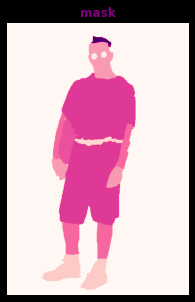

In [ ]:

NORM = mpl.colors.Normalize(vmin=0, vmax=18)
fig = plt.figure(figsize=(10,5), facecolor='black')
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title('mask', color='purple', weight='semibold')
ax1.imshow(new_mask[:,:,0], norm=NORM, cmap='RdPu')
ax1.axis('off')

In [ ]:
def compare_plot(index, mask_max=58):
    n_mask, r_mask, r_img = new_masks[index], masks[index], images[index]
    NORM = mpl.colors.Normalize(vmin=0, vmax=58)
    new_NORM = mpl.colors.Normalize(vmin=0, vmax=18)
    fig = plt.figure(figsize=(15,6), facecolor='black')
    ax1 = fig.add_subplot(1, 5, 1)
    ax1.set_title('items', color='purple', weight='semibold')
    ax1.text(0, 0.5, "\n".join([j for j in list(image_stats.columns) if (image_stats.loc()[f'image_{index}':f'image_{index}'][j] > 0).bool()]), color='purple', weight='semibold')
    ax1.axis('off')
    ax2 = fig.add_subplot(1, 5, 2)
    ax2.set_title('mask', color='purple', weight='semibold')
    ax2.imshow(r_mask[:,:,0], norm=NORM, cmap='RdPu')
    ax2.axis('off')
    ax3 = fig.add_subplot(1, 5, 3)
    ax3.set_title('image', color='purple', weight='semibold')
    ax3.imshow(r_img[:,:,0])
    ax3.axis('off')
    ax4 = fig.add_subplot(1, 5, 4)
    ax4.set_title('mask', color='purple', weight='semibold')
    ax4.imshow(n_mask[:,:,0], norm=new_NORM, cmap='RdPu')
    ax4.axis('off')
    ax5 = fig.add_subplot(1, 5, 5)
    ax5.set_title('items', color='purple', weight='semibold')
    ax5.text(0, 0.5, "\n".join([j for j in list(custom_df.columns) if (custom_df.loc()[f'image_{index}':f'image_{index}'][j] > 0).bool()]), color='purple', weight='semibold')
    ax5.axis('off')
    plt.savefig('pair')
    plt.show()

Now, remember how not all images had skin? I want to check this a little and further quality check the masks. We can see the image lacking skin is all background, so why don't we visualise this with our compare plot function, here we can see the image is indeed of a person wearing clothing, however the structure of this image is different to other images in the dataset. For any other random image visualised beneath the bad mask we can see the format difference ore clearly. The bad mask is not an image of the entire person. We canot see their feet and legs. We can assume from this mask that the segmentation has only been performed on images that have a certain format. 

For the purposes of my model I will not be feeding the model images that are an incorrect format and the model will therefore be valid only for images in the correct format. as such we can remove this image mask pair from the dataset as the presence of similar features has the potential to confuse the model.

In [ ]:
image_stats[image_stats['skin'] == 0]

,background,accessories,bag,belt,blazer,blouse,bodysuit,boots,bra,bracelet,...,sweatshirt,swimwear,t-shirt,tie,tights,top,vest,wallet,watch,wedges
image_536,453750,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


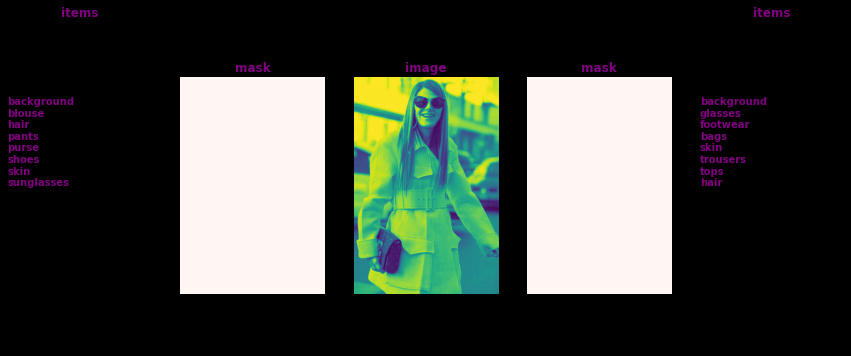

In [ ]:
bad_masks = [535]
compare_plot(535)

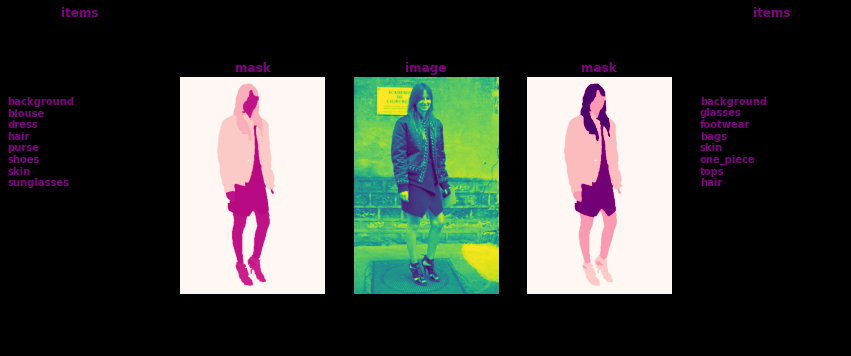

In [ ]:
rand_indx = random.randint(0, 998)
compare_plot(rand_indx)

In [ ]:
images.pop(535)
masks.pop(535)
new_masks.pop(535)
custom_df.drop('image_535', inplace=True)
custom_df.reset_index(drop=True, inplace=True)

# Helpful transformaions before feeding images to the a model

Before modeling though We need to find a way of making our images less computationally expensive and given the small training set try to increase the utility of the images we have. we can do this in a few ways including:
- resize and rescale
- color flatten
- augmentations

for resizing and rescaling. 128 is a standard resize as is 64, we can try each and see how much loss we could tolerate but given our images are currently 825 * 550 64 may be too small to pick out details, particulalry for accessories like rings. We also want to make our intensity between 0 and 1 rather than between 0 and 255 for our images, however for the masks the integer values represent different categories so they will not need transforming.

when thinking about whether or not to greyscale, greyscale works well when contrast between color detection is high, meanwhile for self driving cars where the meaning of a white and yellow lane are different, keeping color is incredibly important. So for people and clothing segmentation we can think any clothing items might be in any color, what makes a skirt a skirt is not its color but its form. In this respect it is likely edge detection and localisation are more important factors in clothing segmentation. Color can be a personal preference or an irrelevant detail. This means how we convert to greyscale and what other transformations we use become important. however this becomes more complex when we consider that some clothes might be skintone and that contrast may play a significant role in the design of outfits.

# Neural nets
Neural Nets in TensorFlow support the use of python classes within their pipelines. I have used a pipleine as it allows random transormations to be applied and random image samples to be used on each training cycle. the increased hetrogentiy of the training data will in theory lead to a more robust model. in adition, the pipeline could be run with or without various transformations in order to suggest which transformations are helpful or unhelpful to our model.

In [ ]:
# this class inherits from the Layer parent class which represents a layer of a neural network, layers can be inserted to a pipeline which trains the model in batches.
# we need to alter the init and call dunder methods which will both be accessed in the pipline
# this is otherwise a simple layer that randomly performs a horizontal transformation on an image and mask pair.

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

before imputing out data into our pipeline we resize each image and mask pair

In [ ]:
def resize_image(images):
    # scale the image: we change the datatype from uint8 to float 32 in order to divide by 255
    image = tf.cast(images, tf.float32)
    image = image/255.0
    # resize image: tensorflow has a function to resize, we can try 128 and 64
    image = tf.image.resize(image, (128,128))
    # image = tf.image.resize(image, (64,64))
    # make image greyscale
    # image = tf.image.rgb_to_grayscale(image[:,:,:])
    # image = tf.image.rgb_to_hsv(image)[:,:,2]
    return image

def resize_mask(masks):
    # resize the mask
    mask = tf.image.resize(masks, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask

images = [resize_image(i) for i in images]
masks = [resize_mask(m) for m in new_masks]

we also make a random list of indexes that will represent the indexes in our train test split. 

In [ ]:
img_indexes = list([i for i in range(998)])
random.seed(64)
random.shuffle(img_indexes)
img_indexes = img_indexes[:200]
img_indexes.sort()
print(img_indexes)

[0, 2, 4, 10, 11, 19, 20, 33, 37, 42, 47, 49, 63, 67, 70, 71, 76, 77, 95, 97, 99, 101, 105, 106, 109, 119, 123, 128, 129, 133, 146, 147, 157, 181, 185, 186, 188, 193, 197, 205, 214, 216, 217, 234, 239, 241, 244, 247, 249, 250, 258, 259, 266, 268, 269, 271, 273, 274, 279, 288, 289, 291, 294, 298, 308, 321, 327, 328, 330, 337, 340, 344, 349, 351, 355, 356, 357, 361, 363, 374, 378, 388, 403, 415, 416, 418, 420, 425, 428, 432, 436, 438, 439, 443, 445, 447, 452, 453, 454, 463, 466, 483, 491, 494, 495, 503, 508, 514, 518, 530, 540, 551, 553, 556, 560, 561, 568, 570, 585, 588, 595, 597, 599, 608, 611, 621, 625, 629, 630, 636, 637, 644, 648, 654, 655, 661, 662, 663, 676, 687, 700, 719, 720, 729, 733, 734, 741, 742, 745, 748, 750, 752, 755, 756, 761, 793, 797, 801, 806, 812, 815, 819, 827, 838, 845, 850, 852, 855, 861, 864, 868, 872, 875, 885, 889, 901, 902, 905, 914, 924, 929, 932, 938, 943, 945, 946, 948, 951, 958, 966, 967, 969, 970, 977, 986, 987, 991, 993, 995, 996]


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

finally we turn our lists into generators. we use logic to sepperate test from train within the generator and turn these generators into datasets using tf.data.Dataset_from_generator

In [ ]:
def train_images():
    i = 0
    while i < len(images):
        if i not in img_indexes and i not in bad_masks:
            yield images[i], masks[i]
        i += 1

def test_images():
    i = 0
    while i < len(images):
        if i in img_indexes and i not in bad_masks:
            yield images[i], masks[i]
        i +=1


train = tf.data.Dataset.from_generator(
    train_images,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.uint8)
    )
)
test = tf.data.Dataset.from_generator(
    test_images,
    output_signature=(
    tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(128, 128, 1), dtype=tf.uint8)
    )
)

Now we have a test and train dataset. For our training dataset we create batches which are shuffled and augmented (we use a horizontal flip but there is room for further augmentation if required)

In [ ]:

TRAIN_LENGTH = len(images) - len(img_indexes)
BATCH_SIZE = 64
BUFFER_SIZE = 300
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


train_batches = (
    train
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(Augment())
        .prefetch(buffer_size=BUFFER_SIZE))

test_batches = test.batch(BATCH_SIZE)

while training we can display the model predictions using the following function. In practice this used more memory than kaggle allows 

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

meanwhile our batched following processing look like this

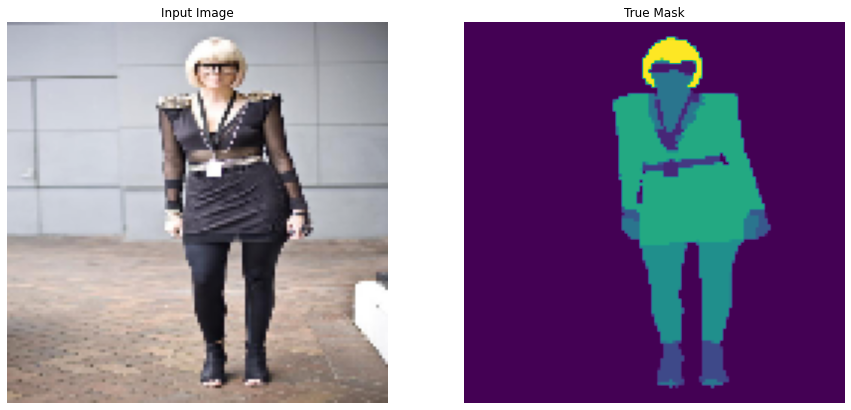

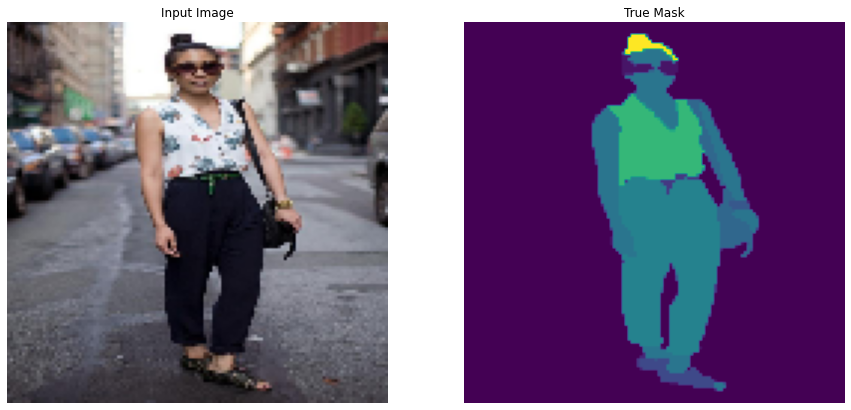

In [ ]:
for _images, _masks in train_batches.take(2):
    sample_image, sample_mask = _images[0], _masks[0]
    display([sample_image, sample_mask])


# The model
in order to make predictions we will use a transfer learning approach. MobileNetV2 is a general purpose neural net that has been pretrained for image recognition. in order to use it for our model we have to specify which layers to use. 

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


we create a function holding both parts of the above model to design a custom neural network which holds each partof the downstack as a kind of memory, and uses the upstack to rebuild from each of the downstacks allowing us to identify features that are small (4 * 4) or large (64 * 64) or somewhere inbetween.

In [ ]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
OUTPUT_CLASSES = 19

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


It is perhaps easier to visualise in the below graph which shows the image inputted into the downstack (Functional) creating 5 outputs. Form the smallest output (4 * 4) we rebuild to a larger output (8 * 8) and concatenate this with the next level of of the model, continuing until we have recreated a 128 by 128 by 19 array where each of the 19 dimensions represent a category in our masks

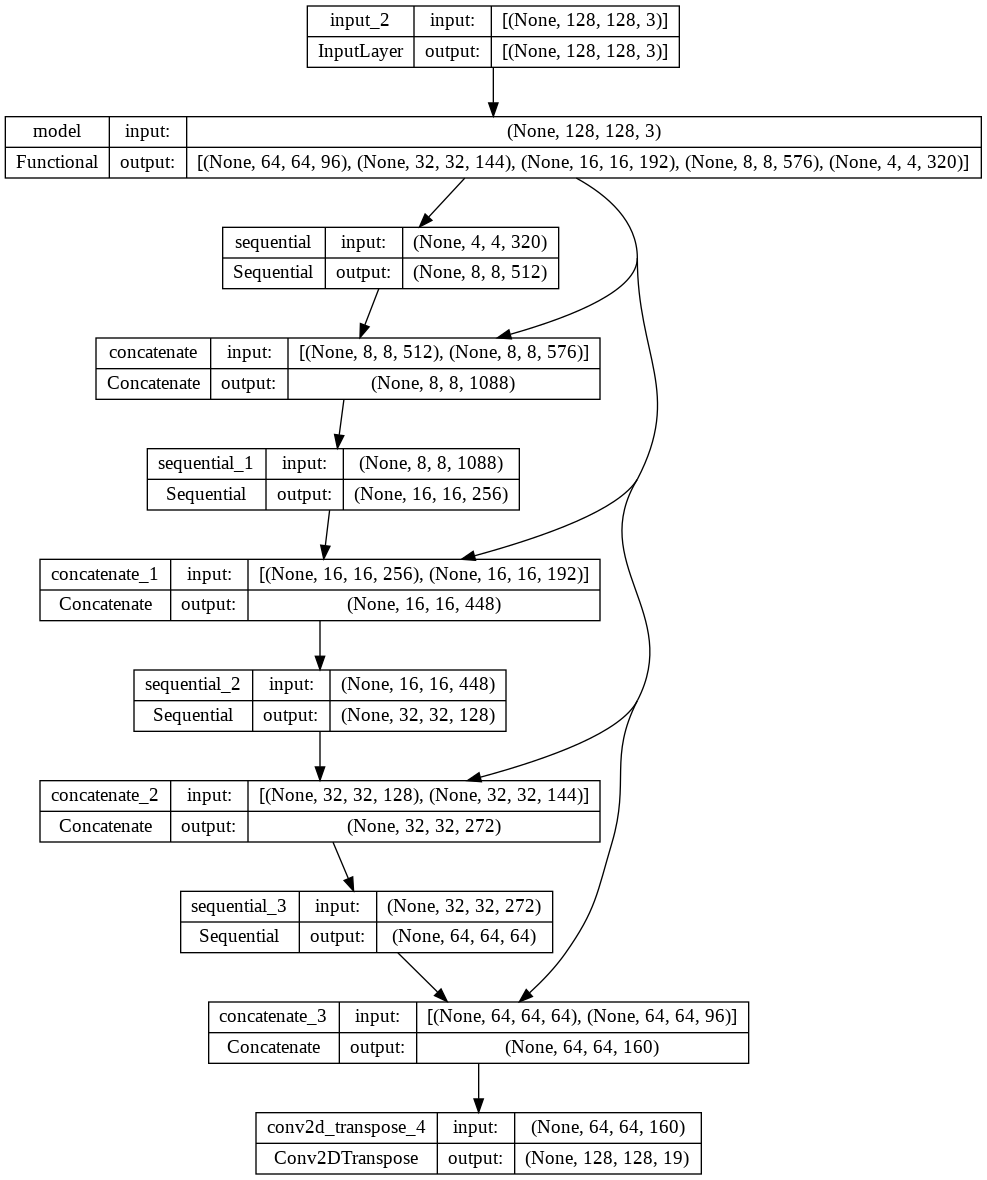

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
NORM = mpl.colors.Normalize(vmin=0, vmax=18)

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def plot_epoch_mask(epoch):
    new_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    plt.imsave(f"{epoch + 1}_epochs_train.png", new_mask.numpy(), cmap='RdPu')  # image is 1 d array?

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        # The following line is quite memory intensive but helps to visualize how the model learns over time
        #plot_epoch_mask(epoch)  
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = (len(images) - len(img_indexes))//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


Sample Prediction after epoch 50

12/12 [==============================] - 2s 162ms/step - loss: 0.1182 - accuracy: 0.9690 - val_loss: 0.5803 - val_accuracy: 0.8597


In [ ]:
plt.imsave(f"sample_image.png", sample_image.numpy())

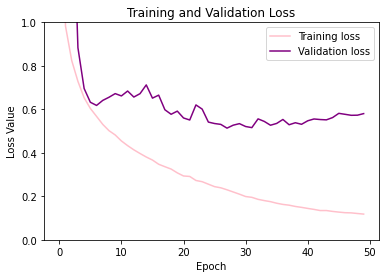

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'pink', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'purple', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()

plt.savefig("loss_bw")
plt.show()

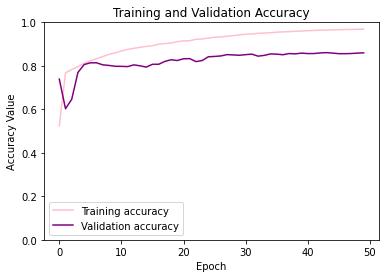

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'pink', label='Training accuracy')
plt.plot(model_history.epoch, val_acc, 'purple', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig("acc_bw")
plt.show()

In [ ]:
plt.imsave("grainy.png", images[852].numpy())

In [ ]:
train_image = images[700]
test_image = images[701]
plt.imsave(f"train_image.png", tf.image.resize(train_image, (825,550)).numpy())
plt.imsave(f"test_image.png", tf.image.resize(test_image, (825,550)).numpy())

In [ ]:
train_real = train_image
test_real = test_image
train_image = tf.image.resize(train_image, (128, 128))
test_image = tf.image.resize(test_image, (128, 128))


In [ ]:
file = tf.io.read_file('/content/img_0702.png')
image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
ang_image = tf.image.resize(image, (128, 128))


file = tf.io.read_file('/content/ofs128.png')
image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
ofs_image = tf.image.resize(image, (128, 128))

NotFoundError: ignored

In [ ]:
train_pred = create_mask(model.predict(train_image[tf.newaxis, ...]))
test_pred = create_mask(model.predict(test_image[tf.newaxis, ...]))

In [ ]:
train_pred = tf.image.resize(train_pred, (825,550)).numpy()
test_pred = tf.image.resize(test_pred, (825,550)).numpy()
train_real = tf.image.resize(sample_image, (825,550)).numpy()
plt.imsave(f"ang_pred.png", train_pred[:,:,0], cmap='RdPu')
plt.imsave(f"ofs_pred.png", test_pred[:,:,0], cmap='RdPu')

In [ ]:
plt.imsave(f"train_image.png", sample_image.numpy())
plt.imsave(f"train_pred.png", sample_image.numpy())
plt.imsave(f"test_image.png", sample_image.numpy())
plt.imsave(f"test_pred.png", sample_image.numpy())